In [1]:
%run init_notebook.py
from settings import DATA_DIR, GRAPHS_DIR

In [15]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import spacy
import regex as re

import chromadb

from uuid import uuid4

from itertools import chain
from collections import Counter

In [3]:
# load ecb speeches

In [4]:
f = open(os.path.join(DATA_DIR, 'ecb_speeches.pickle'), 'rb')
speeches = pickle.load(f)
f.close()

In [7]:
speeches = dict(zip([str(uuid4()) for i in range(0, len(speeches))], list(speeches.values())))

In [8]:
N = -1
documents = [v['text'] for k,v in speeches.items()]
docs_spacy = [v['doc'] for k,v in speeches.items()]
embeds = [list(v['doc'].vector) for k,v in speeches.items()]
metadatas = [{'date': str(v['date']), 'title': v['title'], 'url': v['url']} for k,v in speeches.items()]
ids = list(speeches.keys())
dict_dates = {k: v['date'] for k,v in speeches.items()}

In [9]:
# tf-idf

In [12]:
propns = {
    ids[idx]: 
    [
        t.lemma_ for t in docs_spacy[idx] if 
        (t.pos_ in ["PROPN", "NOUN"]) 
        and re.fullmatch(r"[^a-zA-Z0-9]", t.lemma_) is None
    ] 
    for idx in range(len(docs_spacy))
}

In [13]:
from collections import Counter

In [16]:
tf = {}
for idx, terms in propns.items():
    counter = Counter(terms)
    _freq = np.array(list(counter.values())) / sum(counter.values())
    tf[idx] = dict(zip(counter.keys(), _freq))
    
bag_of_words = list(set([*chain(*[list(i.keys()) for i in list(tf.values())])]))
lst_doc_words = [list(v.keys()) for k,v in tf.items()]
idf = {}
for term in bag_of_words:
    idf[term] = np.log(len(lst_doc_words) / (1 + sum([term in d for d in lst_doc_words]))) + 1

In [21]:
tf_idf = {idx: {k: idf[k] * v for k,v in doc.items()} for idx,doc in tf.items()}

In [56]:
df_tfidf = pd.DataFrame(tf_idf).transpose()
df_tfidf['date'] = df_tfidf.index.map(dict_dates)
df_tfidf.sort_values('date', inplace=True)
df_tfidf.index.name = 'uuid'
df_tfidf.drop('date', axis=1, inplace=True)
# df_tfidf.reset_index(inplace=True)
# df_tfidf.set_index(['], inplace=True)
# df_tfidf.sort_index(inplace=True)

In [70]:
df_tfidf.iloc[-25:].dropna(axis=1).max().sort_values()

President      0.004923
Vice           0.005133
detail         0.005514
conference     0.008015
expectation    0.009212
press          0.010165
assessment     0.011868
interest       0.014747
pressure       0.016466
instrument     0.016503
time           0.016593
sector         0.019136
risk           0.019165
bank           0.020064
condition      0.029231
rate           0.029495
measure        0.032313
euro           0.033989
price          0.034044
term           0.034808
area           0.038927
economy        0.045831
policy         0.060705
inflation      0.063708
dtype: float64

In [80]:
df_tfidf.max().sort_values().iloc[-20:]

cent            0.163040
remark          0.164352
competition     0.186641
planning        0.187669
statistic       0.194949
General         0.200574
banknote        0.204087
supervision     0.207210
premise         0.207252
Solbes          0.207602
presentation    0.216550
Europol         0.220888
co              0.225203
architect       0.228537
breakdown       0.229335
project         0.238941
Rato            0.433017
proposal        0.454882
Mr.             0.525063
design          0.669758
dtype: float64

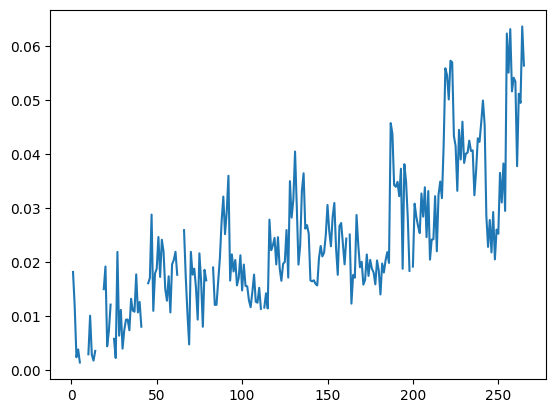

In [81]:
plt.plot(df_tfidf['inflation'].values)

In [ ]:
# chromadb embedding

In [116]:
chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name="test2_collection")

In [122]:
len(metadatas)

266

In [123]:
len(ids)

266

In [124]:
collection.add(
#     embeddings=embeds,
    documents=documents,
    metadatas=metadatas,
    ids=ids
)

In [141]:
results = collection.query(
    query_texts=["rising inflation"],
    n_results=20,
    where_document={"$contains":"inflation"}
)

ValueError: You must provide one of query_embeddings, query_texts, query_images, or query_uris.

In [129]:
x = collection.get(include=['embeddings'])['embeddings']
x = np.array(x)

In [130]:
x.shape

(266, 384)

In [90]:
np.array(embeds).shape

(5, 300)

In [ ]:
speeches